In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2019-Nov.csv
/kaggle/input/2019-Oct.csv


In [2]:
!pip install pyspark

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Kaggle Spark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 14:04:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
spark

In [6]:
df=spark.read.csv('/kaggle/input/2019-Oct.csv',header=True,inferSchema=True)

In [7]:
df.show(5,False)

+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|event_time         |event_type|product_id|category_id        |category_code                      |brand   |price  |user_id  |user_session                        |
+-------------------+----------+----------+-------------------+-----------------------------------+--------+-------+---------+------------------------------------+
|2019-10-01 00:00:00|view      |44600062  |2103807459595387724|NULL                               |shiseido|35.79  |541312140|72d76fde-8bb3-4e00-8c23-a032dfed738c|
|2019-10-01 00:00:00|view      |3900821   |2053013552326770905|appliances.environment.water_heater|aqua    |33.2   |554748717|9333dfbd-b87a-4708-9857-6336556b0fcc|
|2019-10-01 00:00:01|view      |17200506  |2053013559792632471|furniture.living_room.sofa         |NULL    |543.1  |519107250|566511c2-e2e3-422b-b695-cf8e6e792ca8|
|2019-10-01 00:0

In [8]:
df.count()

42448764

In [9]:
df_ecom=df.filter((col('category_code').isNotNull() & (col('brand').isNotNull())))

In [10]:
df_ecom.count()

26560622

In [14]:
df_ecom.where((col('category_code').isNull()) | (col('brand').isNull())).count()

0

In [11]:
df_part=df_ecom.withColumn('user_partition_group',hash(col('user_id'))%100)
df_part.repartition(100,'user_partition_group')
df_part.write.mode('overwrite').partitionBy('user_partition_group').parquet('/kaggle/working/user_partition/')

In [12]:
df_ecom_part=spark.read.parquet('/kaggle/working/user_partition/',inferSchema=True)
df_ecom_part.count()

26560622

In [17]:
user_event_cnt=df_ecom_part.groupBy('user_id','event_type').agg(count('*').alias('event_cnt'))
user_event_cnt.show(5,False)

+---------+----------+---------+
|user_id  |event_type|event_cnt|
+---------+----------+---------+
|517682460|view      |6        |
|515587866|view      |1        |
|542333098|view      |1        |
|519705698|view      |40       |
|513790618|view      |22       |
+---------+----------+---------+
only showing top 5 rows



In [18]:
df_ecom_part.printSchema

<bound method DataFrame.printSchema of DataFrame[event_time: timestamp, event_type: string, product_id: int, category_id: bigint, category_code: string, brand: string, price: double, user_id: int, user_session: string, user_partition_group: int]>

In [19]:
user_event_pivot= user_event_cnt.groupBy('user_id').pivot('event_type',['view','cart','purchase']).sum('event_cnt').na.fill(0)
user_event_pivot.show(5,False)

+---------+----+----+--------+
|user_id  |view|cart|purchase|
+---------+----+----+--------+
|517682460|6   |1   |2       |
|519705698|40  |0   |0       |
|515406162|173 |0   |0       |
|523367237|46  |1   |1       |
|527916573|20  |3   |0       |
+---------+----+----+--------+
only showing top 5 rows



In [20]:
user_event_pivot = user_event_pivot.withColumn(
                                            "view_to_cart_rate", when(col("view") == 0, 0).otherwise(col("cart") / col("view"))
                                        ).withColumn(
                                            "cart_to_purchase_rate", when(col("cart") == 0, 0).otherwise(col("purchase") / col("cart"))
                                        ).withColumn(
                                            "view_to_purchase_rate", when(col("view") == 0, 0).otherwise(col("purchase") / col("view"))
                                        )
user_event_pivot.show(5, truncate=False)

+---------+----+----+--------+--------------------+---------------------+---------------------+
|user_id  |view|cart|purchase|view_to_cart_rate   |cart_to_purchase_rate|view_to_purchase_rate|
+---------+----+----+--------+--------------------+---------------------+---------------------+
|517682460|6   |1   |2       |0.16666666666666666 |2.0                  |0.3333333333333333   |
|519705698|40  |0   |0       |0.0                 |0.0                  |0.0                  |
|515406162|173 |0   |0       |0.0                 |0.0                  |0.0                  |
|523367237|46  |1   |1       |0.021739130434782608|1.0                  |0.021739130434782608 |
|527916573|20  |3   |0       |0.15                |0.0                  |0.0                  |
+---------+----+----+--------+--------------------+---------------------+---------------------+
only showing top 5 rows



In [21]:
user_catg_behv = df_ecom_part.groupBy('user_id','category_code','event_type').agg(count('*').alias('user_catg_evnt_cnt'))
user_catg_behv.orderBy('user_id','user_catg_evnt_cnt',ascending=False).show(5,False)

+---------+---------------------------+----------+------------------+
|user_id  |category_code              |event_type|user_catg_evnt_cnt|
+---------+---------------------------+----------+------------------+
|566280697|electronics.camera.video   |view      |1                 |
|566280676|furniture.bedroom.bed      |view      |1                 |
|566280663|electronics.smartphone     |view      |2                 |
|566280422|auto.accessories.player    |view      |3                 |
|566280399|electronics.audio.headphone|view      |6                 |
+---------+---------------------------+----------+------------------+
only showing top 5 rows



In [22]:
user_brand_behv = df_ecom_part.groupBy("user_id", "brand", "event_type").agg(count("*").alias("event_count"))
user_brand_behv.orderBy("user_id", "event_count", ascending=False).show(10, truncate=False)

+---------+----------+----------+-----------+
|user_id  |brand     |event_type|event_count|
+---------+----------+----------+-----------+
|566280697|dji       |view      |1          |
|566280676|stendmebel|view      |1          |
|566280663|apple     |view      |2          |
|566280422|kenwood   |view      |3          |
|566280399|sony      |view      |2          |
|566280399|fender    |view      |1          |
|566280399|harper    |view      |1          |
|566280399|apple     |view      |1          |
|566280399|jbl       |view      |1          |
|566280378|magnetta  |view      |2          |
+---------+----------+----------+-----------+
only showing top 10 rows



In [23]:
user_catg_brand_behv= df_ecom_part.groupBy('user_id','category_code','brand','event_type').agg(count('*').alias('user_catg_brand_cnt'))
user_catg_brand_behv.orderBy('user_id','category_code','user_catg_brand_cnt',ascending=False).show(5,False)

+---------+---------------------------+----------+----------+-------------------+
|user_id  |category_code              |brand     |event_type|user_catg_brand_cnt|
+---------+---------------------------+----------+----------+-------------------+
|566280697|electronics.camera.video   |dji       |view      |1                  |
|566280676|furniture.bedroom.bed      |stendmebel|view      |1                  |
|566280663|electronics.smartphone     |apple     |view      |2                  |
|566280422|auto.accessories.player    |kenwood   |view      |3                  |
|566280399|electronics.audio.headphone|sony      |view      |2                  |
+---------+---------------------------+----------+----------+-------------------+
only showing top 5 rows



In [24]:
user_catg_brand_behv.filter((col('category_code')=='electronics.audio.headphone') & (col('event_type')=='purchase')).orderBy(col('user_catg_brand_cnt').desc()).show()

+---------+--------------------+-------+----------+-------------------+
|  user_id|       category_code|  brand|event_type|user_catg_brand_cnt|
+---------+--------------------+-------+----------+-------------------+
|514179041|electronics.audio...|  apple|  purchase|                 72|
|523272971|electronics.audio...|  apple|  purchase|                 47|
|530206193|electronics.audio...|  apple|  purchase|                 43|
|529306305|electronics.audio...|  apple|  purchase|                 40|
|516340491|electronics.audio...|  apple|  purchase|                 35|
|543953918|electronics.audio...| xiaomi|  purchase|                 34|
|552949638|electronics.audio...|  apple|  purchase|                 31|
|516993548|electronics.audio...|  apple|  purchase|                 29|
|516492996|electronics.audio...|    jbl|  purchase|                 27|
|540965270|electronics.audio...|  apple|  purchase|                 27|
|538648461|electronics.audio...|  apple|  purchase|             

In [25]:
w_brand_rank = Window.partitionBy('user_id','category_code','event_type').orderBy(col('user_catg_brand_cnt').desc())
user_top_brand_in_catg = user_catg_brand_behv.withColumn('rank',row_number().over(w_brand_rank)) #.filter(col('rank')==1)
user_top_brand_in_catg.orderBy('user_id','category_code','rank',ascending=False).show()

+---------+--------------------+----------+----------+-------------------+----+
|  user_id|       category_code|     brand|event_type|user_catg_brand_cnt|rank|
+---------+--------------------+----------+----------+-------------------+----+
|566280697|electronics.camer...|       dji|      view|                  1|   1|
|566280676|furniture.bedroom...|stendmebel|      view|                  1|   1|
|566280663|electronics.smart...|     apple|      view|                  2|   1|
|566280422|auto.accessories....|   kenwood|      view|                  3|   1|
|566280399|electronics.audio...|       jbl|      view|                  1|   5|
|566280399|electronics.audio...|    harper|      view|                  1|   4|
|566280399|electronics.audio...|     apple|      view|                  1|   3|
|566280399|electronics.audio...|    fender|      view|                  1|   2|
|566280399|electronics.audio...|      sony|      view|                  2|   1|
|566280378|construction.tool...|  magnet

In [26]:
user_top_brand_in_catg.filter((col('category_code')=='electronics.audio.headphone')  & (col('user_id')=='566280399') & (col('event_type') =='cart')).orderBy('rank',ascending=False).show(5,False)

+-------+-------------+-----+----------+-------------------+----+
|user_id|category_code|brand|event_type|user_catg_brand_cnt|rank|
+-------+-------------+-----+----------+-------------------+----+
+-------+-------------+-----+----------+-------------------+----+



In [27]:
user_top_brand_in_catg.filter(col('rank') >= 2).show()

+---------+--------------------+--------+----------+-------------------+----+
|  user_id|       category_code|   brand|event_type|user_catg_brand_cnt|rank|
+---------+--------------------+--------+----------+-------------------+----+
|240522111|electronics.audio...| samsung|      view|                  1|   2|
|265601964|electronics.smart...| samsung|      view|                  1|   2|
|277655927|appliances.enviro...| karcher|      view|                  6|   2|
|277655927|appliances.enviro...|   bosch|      view|                  3|   3|
|277655927|appliances.enviro...| philips|      view|                  2|   4|
|282977436|electronics.video.tv|    sony|      view|                  7|   2|
|282977436|electronics.video.tv| samsung|      view|                  2|   3|
|301573329|  computers.notebook|  lenovo|      view|                  1|   2|
|301573329|  computers.notebook|    asus|      view|                  1|   3|
|304501389|electronics.smart...|    vivo|      view|            

## Session Analysis

In [28]:
df_time=df_ecom_part.withColumn('event_hour',hour('event_time')) \
                    .withColumn('event_day',dayofweek('event_time'))
hourly_activity=df_time.groupBy('event_hour','event_type').agg(count('*').alias('event_hour_cnt')).orderBy(col('event_hour_cnt').desc())
hourly_activity.show(5,False)

+----------+----------+--------------+
|event_hour|event_type|event_hour_cnt|
+----------+----------+--------------+
|16        |view      |1820541       |
|15        |view      |1792304       |
|17        |view      |1619499       |
|14        |view      |1615637       |
|13        |view      |1420848       |
+----------+----------+--------------+
only showing top 5 rows



In [29]:
daily_activity=df_time.groupBy('event_day','event_type').agg(count('*').alias('event_day_cnt')).orderBy(col('event_day_cnt').desc())
daily_activity.show(5,False)

+---------+----------+-------------+
|event_day|event_type|event_day_cnt|
+---------+----------+-------------+
|3        |view      |4001579      |
|4        |view      |3937833      |
|5        |view      |3824316      |
|1        |view      |3481148      |
|6        |view      |3452381      |
+---------+----------+-------------+
only showing top 5 rows



In [31]:
hourly_pd=hourly_activity.toPandas()
daily_pd=daily_activity.toPandas()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

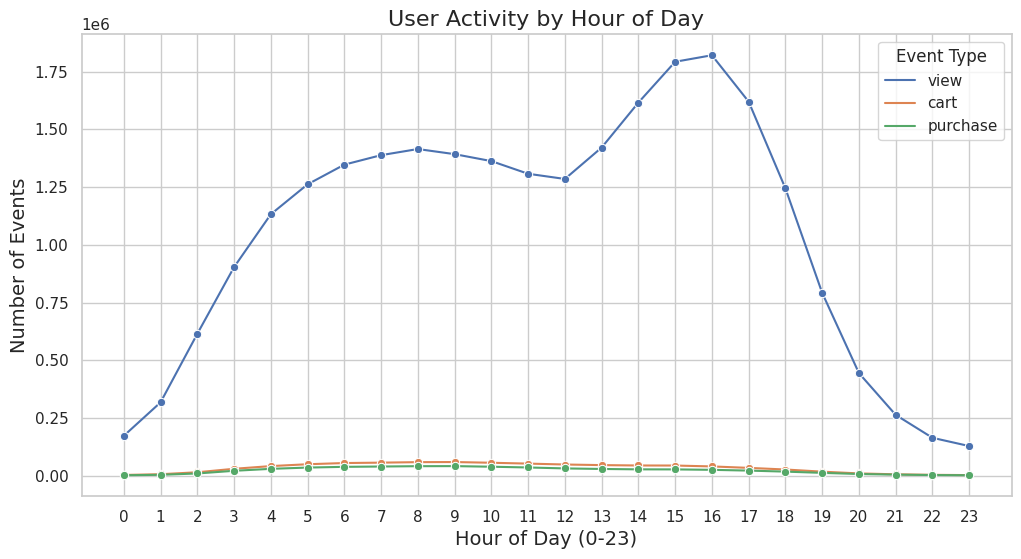

In [32]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_pd, x="event_hour", y="event_hour_cnt", hue="event_type", marker="o")
plt.title("User Activity by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day (0-23)", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.xticks(range(0,24))
plt.show()

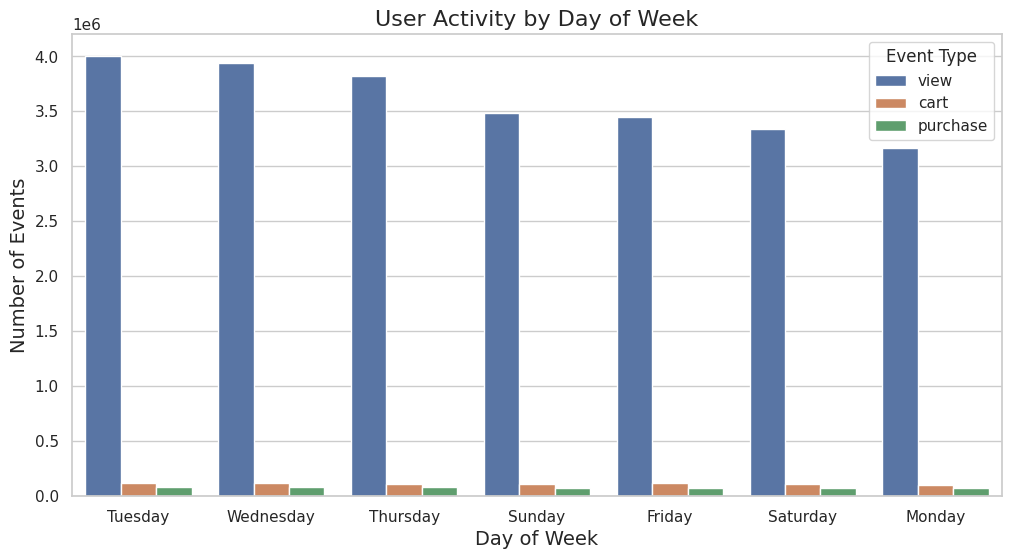

In [33]:
day_mapping = {
    1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
    5: "Thursday", 6: "Friday", 7: "Saturday"
}
daily_pd["day_name"] = daily_pd["event_day"].map(day_mapping)

plt.figure(figsize=(12,6))
sns.barplot(data=daily_pd, x="day_name", y="event_day_cnt", hue="event_type")
plt.title("User Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

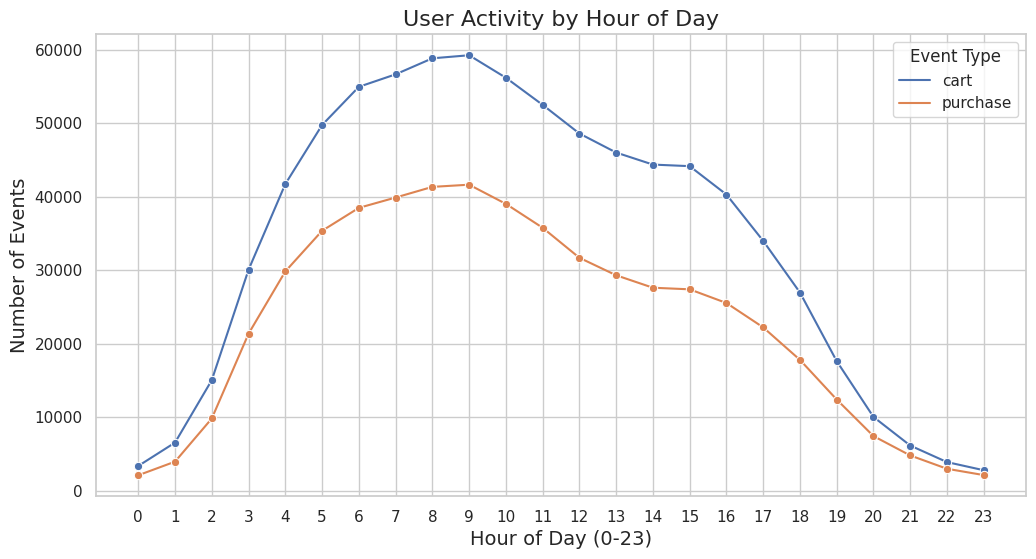

In [34]:
hourly_activity_filtered=hourly_activity.filter(col('event_type') != 'view')
hourly_filtered_pd=hourly_activity_filtered.toPandas()

sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_filtered_pd, x="event_hour", y="event_hour_cnt", hue="event_type", marker="o")
plt.title("User Activity by Hour of Day", fontsize=16)
plt.xlabel("Hour of Day (0-23)", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.xticks(range(0,24))
plt.show()

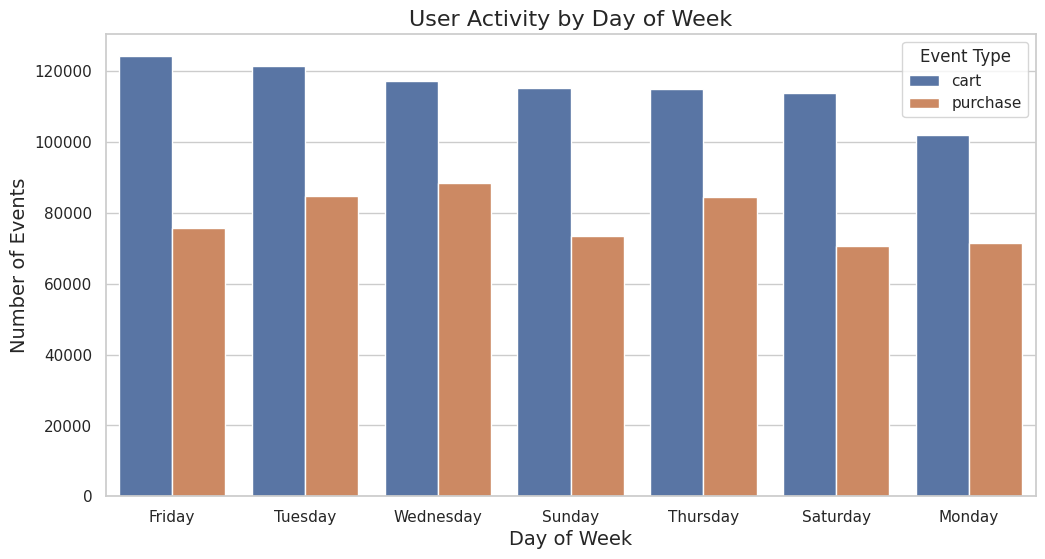

In [35]:
daily_activity_filtered=daily_activity.filter(col('event_type') != 'view')
daily_filtered_pd=daily_activity_filtered.toPandas()

day_mapping = {
    1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday",
    5: "Thursday", 6: "Friday", 7: "Saturday"
}
daily_filtered_pd["day_name"] = daily_filtered_pd["event_day"].map(day_mapping)

plt.figure(figsize=(12,6))
sns.barplot(data=daily_filtered_pd, x="day_name", y="event_day_cnt", hue="event_type")
plt.title("User Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(title="Event Type")
plt.show()

In [36]:
df_ecom_part.select('product_id').distinct().count()

60371

In [37]:
df_ratings = df_ecom_part.withColumn('item_id',concat_ws('_',col('category_code'),col('brand')))
df_ratings = df_ratings.withColumn('ratings',when(col('event_type')=='view',1) \
                                            .when(col('event_type')=='cart',3) \
                                            .when(col('event_type')=='purchase',5)) \
                        .select('user_id','item_id','ratings')
df_ratings.show(5,False)

+---------+-----------------------------------------+-------+
|user_id  |item_id                                  |ratings|
+---------+-----------------------------------------+-------+
|513996137|appliances.kitchen.hob_midea             |1      |
|515182686|appliances.environment.air_heater_timberk|1      |
|555994208|furniture.kitchen.chair_selby            |1      |
|513156537|appliances.iron_vitek                    |1      |
|530310447|apparel.shoes.keds_strobbs               |1      |
+---------+-----------------------------------------+-------+
only showing top 5 rows



In [38]:
item_indexer = StringIndexer(inputCol="item_id", outputCol="item_id_index")
user_indexer = StringIndexer(inputCol="user_id", outputCol="user_id_index")

# Fit and transform
df_ratings = item_indexer.fit(df_ratings).transform(df_ratings)
df_ratings = user_indexer.fit(df_ratings).transform(df_ratings)

df_ratings.show(5)

25/05/06 13:52:49 WARN DAGScheduler: Broadcasting large task binary with size 72.2 MiB  (0 + 0) / 1]


+---------+--------------------+-------+-------------+-------------+
|  user_id|             item_id|ratings|item_id_index|user_id_index|
+---------+--------------------+-------+-------------+-------------+
|513996137|appliances.kitche...|      1|        320.0|     309412.0|
|515182686|appliances.enviro...|      1|        377.0|      49254.0|
|555994208|furniture.kitchen...|      1|        325.0|     602580.0|
|513156537|appliances.iron_v...|      1|        174.0|     201532.0|
|530310447|apparel.shoes.ked...|      1|         83.0|    1566860.0|
+---------+--------------------+-------+-------------+-------------+
only showing top 5 rows



In [39]:
ratings_sampled = df_ratings.sample(fraction=0.1, seed=42)
(training, test) = ratings_sampled.randomSplit([0.8, 0.2], seed=42)

als = ALS(
    userCol="user_id_index",
    itemCol="item_id_index",
    ratingCol="ratings",
    implicitPrefs=True,
    coldStartStrategy="drop",
    rank=10,
    maxIter=10,
    regParam=0.1
)

model=als.fit(training)
user_recommendations = model.recommendForAllUsers(5)
user_recommendations.show(5)

recommendations_flat = user_recommendations.withColumn("rec", explode("recommendations")) \
    .select(
        "user_id",
        col("rec.item_id").alias("item_id"),
        col("rec.ratings").alias("predicted_rating")
    )

recommendations_flat.show(5)

25/05/06 13:53:37 WARN DAGScheduler: Broadcasting large task binary with size 72.2 MiB  (0 + 0) / 1]
25/05/06 13:53:52 WARN DAGScheduler: Broadcasting large task binary with size 72.2 MiB(0 + 0) / 268]
[Stage 117:>                                                                          (0 + 4) / 268]
Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "Spark Context Cleaner"

Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "refresh progress"

Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "RemoteBlock-temp-file-clean-thread"

Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "netty-rpc-env-timeout"

Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "executor-heartbeater"


KeyboardInterrupt: 


Exception: java.lang.OutOfMemoryError thrown from the UncaughtExceptionHandler in thread "driver-heartbeater"


ConnectionRefusedError: [Errno 111] Connection refused

In [13]:
# First, let's create a customer journey dataset
from pyspark.sql.functions import min as spark_min, max as spark_max

# Create a customer-product interaction timeline
customer_journey = df_ecom_part.groupBy('user_id', 'product_id', 'category_code', 'brand') \
    .agg(
        spark_min('event_time').alias('first_view_time'),
        spark_max('event_time').alias('last_interaction_time'),
        count(when(col('event_type') == 'view', 1)).alias('view_count'),
        count(when(col('event_type') == 'cart', 1)).alias('cart_count'),
        count(when(col('event_type') == 'purchase', 1)).alias('purchase_count'),
        collect_list(struct('event_time', 'event_type')).alias('interaction_sequence')
    ) \
    .withColumn('days_to_purchase', 
                when(col('purchase_count') > 0,
                    datediff(col('last_interaction_time'), col('first_view_time')))
                .otherwise(None)) \
    .withColumn('purchase_status', 
                when(col('purchase_count') > 0, 'Purchased')
                .when(col('cart_count') > 0, 'Abandoned in Cart')
                .otherwise('Viewed Only'))


In [14]:
customer_journey.cache()
customer_journey.show(5, truncate=False)

25/05/06 14:16:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_45 in memory.
25/05/06 14:16:42 WARN MemoryStore: Not enough space to cache rdd_52_45 in memory! (computed 384.0 B so far)
25/05/06 14:16:42 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_46 in memory.
25/05/06 14:16:42 WARN MemoryStore: Not enough space to cache rdd_52_46 in memory! (computed 384.0 B so far)
25/05/06 14:16:42 WARN BlockManager: Persisting block rdd_52_45 to disk instead.
25/05/06 14:16:42 WARN BlockManager: Persisting block rdd_52_46 to disk instead.
25/05/06 14:16:50 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_57 in memory.
25/05/06 14:16:50 WARN MemoryStore: Not enough space to cache rdd_52_57 in memory! (computed 384.0 B so far)
25/05/06 14:16:50 WARN BlockManager: Persisting block rdd_52_57 to disk instead.
25/05/06 14:16:50 WARN Memor

+---------+----------+-----------------------------+---------+-------------------+---------------------+----------+----------+--------------+---------------------------------------------------------------------------------------+----------------+---------------+
|user_id  |product_id|category_code                |brand    |first_view_time    |last_interaction_time|view_count|cart_count|purchase_count|interaction_sequence                                                                   |days_to_purchase|purchase_status|
+---------+----------+-----------------------------+---------+-------------------+---------------------+----------+----------+--------------+---------------------------------------------------------------------------------------+----------------+---------------+
|277067319|3701151   |appliances.environment.vacuum|felisatti|2019-10-02 03:13:29|2019-10-02 03:13:29  |1         |0         |0             |[{2019-10-02 03:13:29, view}]                                         

In [15]:
# Convert to pandas for visualization (sampling for performance)
journey_sample = customer_journey.sample(fraction=0.01, seed=42).toPandas()

25/05/06 14:21:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_11 in memory.
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_11 in memory! (computed 384.0 B so far)
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_9 in memory! (computed 8.8 MiB so far)
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_10 in memory! (computed 8.8 MiB so far)
25/05/06 14:21:03 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_12 in memory.
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_12 in memory! (computed 384.0 B so far)
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_13 in memory! (computed 1352.7 KiB so far)
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_14 in memory! (computed 8.7 MiB so far)
25/05/06 14:21:03 WARN MemoryStore: Not enough space to cache rdd_52_15 in m

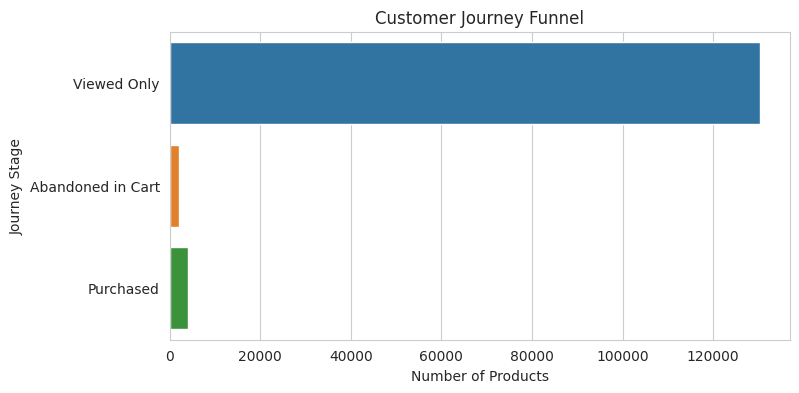

In [71]:
# Visualization 1: Customer Journey Funnel
plt.figure(figsize=(8, 4))
funnel_data = journey_sample.groupby('purchase_status').size().reset_index(name='count')
sns.barplot(x='count', y='purchase_status', data=funnel_data, \
            order=['Viewed Only', 'Abandoned in Cart', 'Purchased'])
plt.title('Customer Journey Funnel')
plt.xlabel('Number of Products')
plt.ylabel('Journey Stage')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


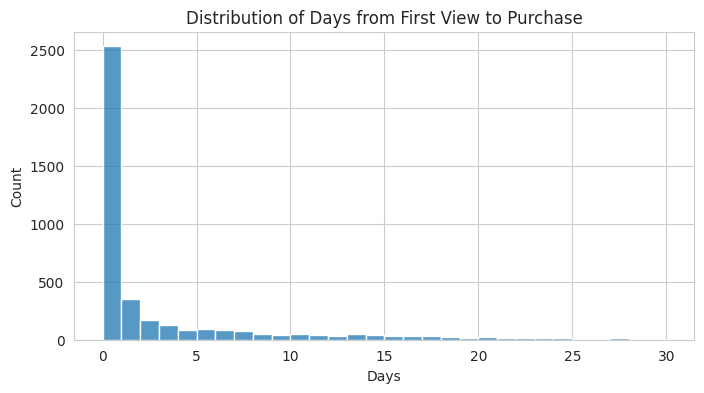

In [74]:
# Visualization 2: Time to Purchase Distribution
plt.figure(figsize=(8, 4))
sns.histplot(journey_sample[journey_sample['days_to_purchase'].notna()]['days_to_purchase'], \
             bins=30)
plt.title('Distribution of Days from First View to Purchase')
plt.xlabel('Days')
plt.ylabel('Count')
plt.show()

/tmp/ipykernel_31/1371254958.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abandoned_cart['top_category'] = abandoned_cart['category_code'].str.split('.').str[0]


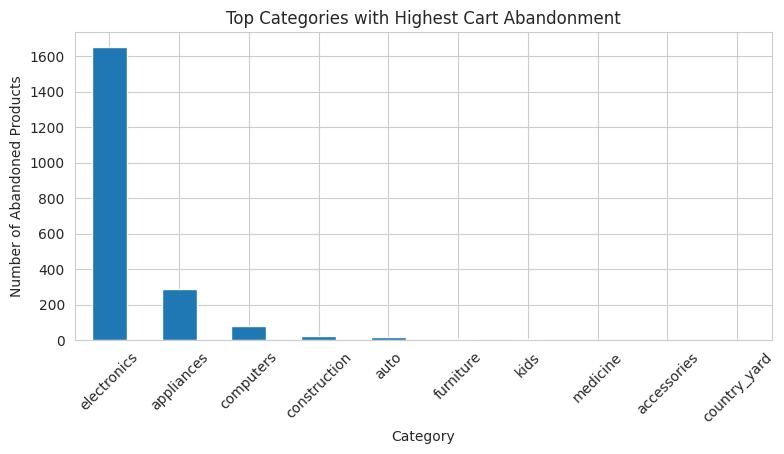

In [75]:
# Visualization 3: Abandoned Cart Analysis by Category
abandoned_cart = journey_sample[(journey_sample['cart_count'] > 0) & \
(journey_sample['purchase_count'] == 0)]

# Extract top level category
abandoned_cart['top_category'] = abandoned_cart['category_code'].str.split('.').str[0]

plt.figure(figsize=(9, 4))
abandoned_by_category = abandoned_cart.groupby('top_category').size().sort_values(ascending=False).\
head(10)
abandoned_by_category.plot(kind='bar')
plt.title('Top Categories with Highest Cart Abandonment')
plt.xlabel('Category')
plt.ylabel('Number of Abandoned Products')
plt.xticks(rotation=45)
plt.show()

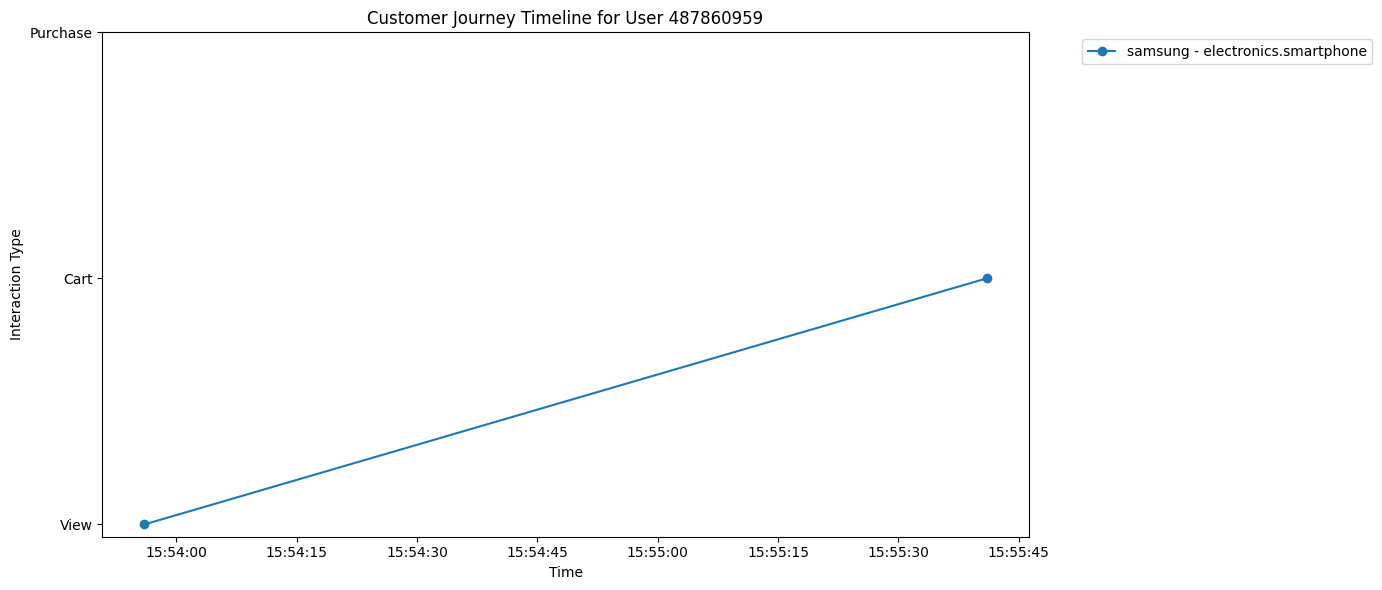

In [63]:

# Visualization 4: Customer Journey Sequence Analysis (for a sample customer)
sample_user = journey_sample['user_id'].sample(1).values[0]
user_journey = journey_sample[journey_sample['user_id'] == sample_user]

# Create a timeline visualization
plt.figure(figsize=(14, 6))
for idx, row in user_journey.iterrows():
    events = sorted(row['interaction_sequence'], key=lambda x: x['event_time'])
    event_types = [e['event_type'] for e in events]
    event_times = [pd.to_datetime(e['event_time']) for e in events]
    
    # Map event types to y-values
    y_map = {'view': 1, 'cart': 2, 'purchase': 3}
    y_values = [y_map[e] for e in event_types]
    
    plt.plot(event_times, y_values, marker='o', label=f"{row['brand']} - {row['category_code']}")

plt.yticks([1, 2, 3], ['View', 'Cart', 'Purchase'])
plt.title(f'Customer Journey Timeline for User {sample_user}')
plt.xlabel('Time')
plt.ylabel('Interaction Type')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

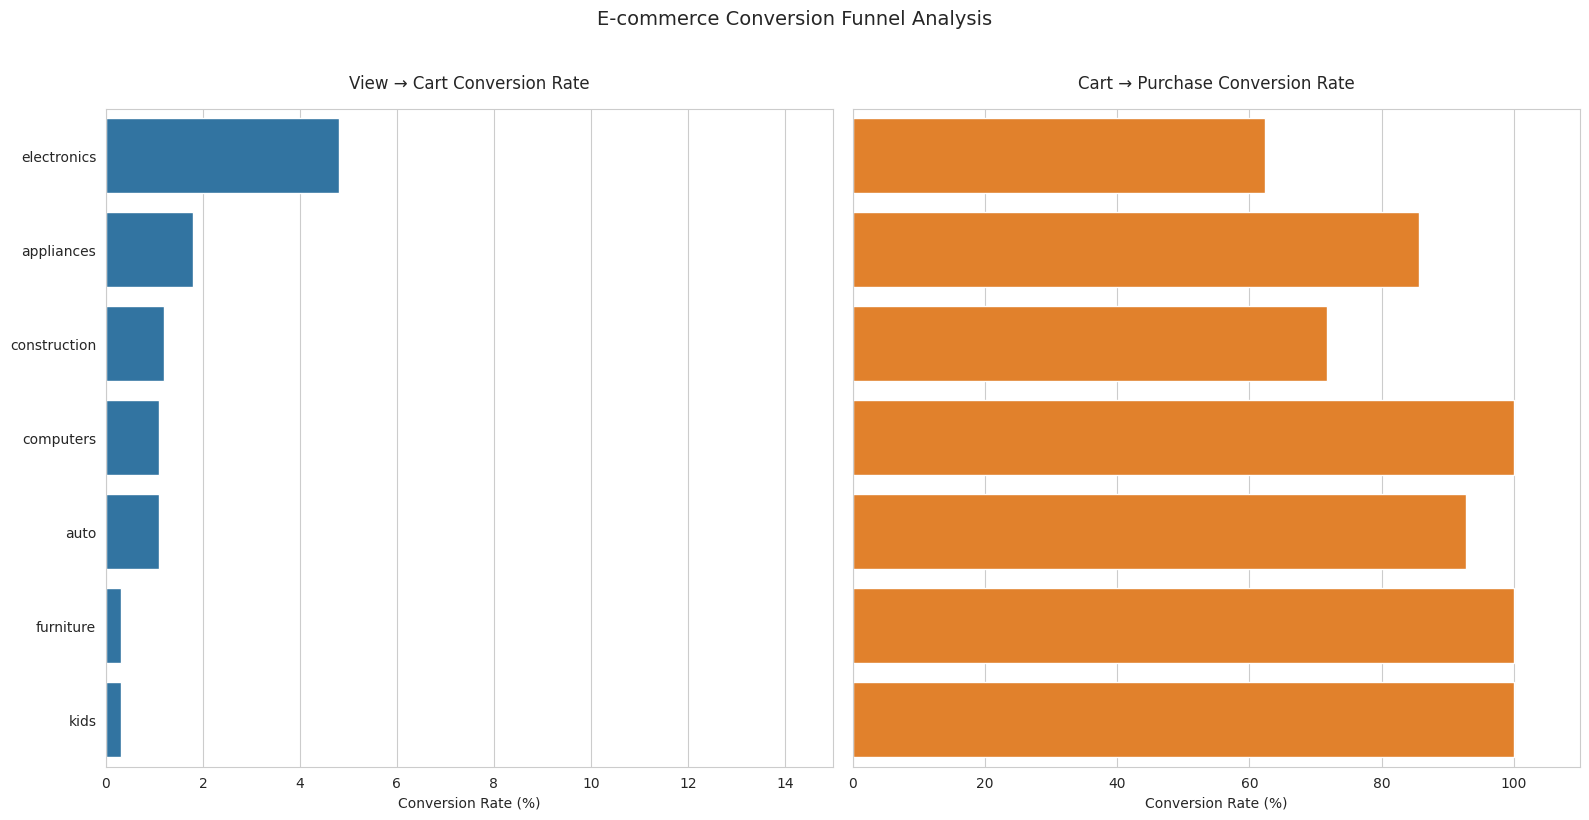

In [67]:
# Visualization 5:  Conversion Rate Analysis

#  Data Preparation with Additional Checks
journey_sample['top_category'] = journey_sample['category_code'].str.split('.').str[0]

# Calculate conversion rates with safeguards
conversion_rates['view_to_cart_rate'] = (conversion_rates['total_carts'] / 
                                        conversion_rates['total_views'].replace(0, 1)).clip(0, 1)
conversion_rates['cart_to_purchase_rate'] = (conversion_rates['total_purchases'] / 
                                           conversion_rates['total_carts'].replace(0, 1)).clip(0, 1)

# Convert to percentages and handle edge cases
conversion_rates['view_to_cart_pct'] = (conversion_rates['view_to_cart_rate'] * 100).round(1)
conversion_rates['cart_to_purchase_pct'] = (conversion_rates['cart_to_purchase_rate'] * 100).round(1)

# Filter out categories with insufficient data or invalid rates
valid_categories = conversion_rates[
    (conversion_rates['total_views'] >= 100) &
    (conversion_rates['total_carts'] >= 10) &
    (conversion_rates['view_to_cart_pct'] <= 100) &
    (conversion_rates['cart_to_purchase_pct'] <= 100)
].sort_values('view_to_cart_pct', ascending=False)

# Enhanced Visualization
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

# Plot View to Cart rates
sns.barplot(x='view_to_cart_pct', y='top_category', data=valid_categories, 
            color='#1f77b4', ax=ax1)
ax1.set_title('View → Cart Conversion Rate', pad=15)
ax1.set_xlabel('Conversion Rate (%)')
ax1.set_ylabel('')
ax1.set_xlim(0, 15)  # Adjusted for typical e-commerce ranges

# Plot Cart to Purchase rates
sns.barplot(x='cart_to_purchase_pct', y='top_category', data=valid_categories, 
            color='#ff7f0e', ax=ax2)
ax2.set_title('Cart → Purchase Conversion Rate', pad=15)
ax2.set_xlabel('Conversion Rate (%)')
ax2.set_ylabel('')
ax2.set_xlim(0, 110)



# Add common title
plt.suptitle('E-commerce Conversion Funnel Analysis', 
             y=1.02, fontsize=14)

plt.tight_layout()
plt.show()



In [21]:
# Save the customer journey data for further analysis
customer_journey.write.mode('overwrite').parquet('/kaggle/working/customer_journey/')

25/05/06 14:24:44 WARN MemoryStore: Not enough space to cache rdd_52_9 in memory! (computed 8.8 MiB so far)
25/05/06 14:24:45 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_11 in memory.
25/05/06 14:24:45 WARN MemoryStore: Not enough space to cache rdd_52_10 in memory! (computed 8.8 MiB so far)
25/05/06 14:24:45 WARN MemoryStore: Not enough space to cache rdd_52_11 in memory! (computed 384.0 B so far)
25/05/06 14:24:46 WARN MemoryStore: Failed to reserve initial memory threshold of 1024.0 KiB for computing block rdd_52_12 in memory.
25/05/06 14:24:46 WARN MemoryStore: Not enough space to cache rdd_52_12 in memory! (computed 384.0 B so far)
25/05/06 14:24:46 WARN MemoryStore: Not enough space to cache rdd_52_13 in memory! (computed 1352.7 KiB so far)
25/05/06 14:24:46 WARN MemoryStore: Not enough space to cache rdd_52_14 in memory! (computed 8.7 MiB so far)
25/05/06 14:24:47 WARN MemoryStore: Not enough space to cache rdd_52_15 in m